# Appendix


## Compressed Sparse Row (CSR) format

CSR format is implemented in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). This consists of three arrays called `indptr`, `indices`, and `data`. For example,

In [1]:
import networkx as nx
from scipy import sparse

G = nx.karate_club_graph()
A = sparse.csr_matrix(nx.adjacency_matrix(G))

print("A.indices:", A.indices[:5])
print("A.indptr:", A.indptr[:5])
print("A.data:", A.data[:5])

A.indices: [1 2 3 4 5]
A.indptr: [ 0 16 25 35 41]
A.data: [4 5 3 3 3]


We will walk you through what these arrays mean, how they are generated, and how we can leverage them for efficient computations.

### How to generate CSR format from an adjacency matrix

Let's walk you through how to store an example adjacency matrix in Compressed Sparse Row (CSR) format. Our example adjacency matrix is as follows.

<div align="center">

|      |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |
| ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: |
|    0 |      |      |      |      |      |      |      |      |      |      |    1 |
|    1 |      |      |    1 |      |      |      |      |      |      |      |    1 |
|    2 |      |    1 |      |    1 |      |      |      |      |      |      |    1 |
|    3 |      |      |    1 |      |    1 |    1 |    1 |      |      |      |      |
|    4 |      |      |      |    1 |      |      |      |    1 |      |      |      |
|    5 |      |      |      |    1 |      |      |      |      |      |      |      |
|    6 |      |      |      |    1 |      |      |      |      |    1 |    1 |      |
|    7 |      |      |      |      |    1 |      |      |      |      |      |      |
|    8 |      |      |      |      |      |      |    1 |      |      |      |    1 |
|    9 |      |      |      |      |      |      |    1 |      |      |      |    1 |
|   10 |    1 |    1 |    1 |      |      |      |      |      |    1 |    1 |      |
</div>

We will first create **adjacency list**, which is a dictionary consisting of the row IDs and column IDs for the non-zero entries in the adjacency matrix.

<div class="container" align="center">
<div class="col" style="margin-top:0%">

$\{\text{Row ID}: (\text{Column ID}, \text{Value})\}$

</div>
</div>

Concretely, in Python,

In [2]:
adj_list = {
  0:[(10,1)],
  1:[(2,1), (10, 1)],
  2:[(1,1), (3,1), (10, 1)],
  3:[(2,1), (4,1), (5,1), (6,1)],
  #...
}

CSR format is a *concatenation* of the keys and values of the adjacency list, respectively. The CSR format has a concatenated array of the values, one for column IDs and one for the values, called `indices` and `data`, respectively.

In [3]:
import numpy as np

indices = np.array([vv[0] for k, v in adj_list.items() for vv in v])
indices

array([10,  2, 10,  1,  3, 10,  2,  4,  5,  6])

In [4]:
data = np.array([vv[1] for k, v in adj_list.items() for vv in v])
data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Additionally, the CSR format has another array called `indptr`, which stores the Row IDs of the non-zero entries in the adjacency matrix. This `indptr` array has a value such that `indptr[i]` is the first index of `indices` that corresponds to the `i`-th row of the adjacency matrix. This can be generated by

In [5]:
indptr = np.cumsum([0] + [len(adj_list[i]) for i in range(len(adj_list))])
indptr

array([ 0,  1,  3,  6, 10])

where we added `0` at the beginning of the array to represent the first non-zero entry in the first row.
The first row ends at index `len(adj_list[0])-1`, and the second row starts at index `len(adj_list[0])` and ends at index `len(adj_list[0])+len(adj_list[1])-1`, and so on.

Now we have three compressed vectors `indptr`, `indices`, and `data`, that together form the CSR format for the adjacency matrix.


### How to use CSR format for efficient computations

The key advantage of the CSR representation is the memory efficiency. But you can leverage the CSR format for more efficient computations, if you know the semantics of `indptr`, `indices`, and `data` arrays.

For instance, one can compute the degree of a node by using

In [6]:
node = 1
degree = indptr[node+1] - indptr[node]
degree

2

Let us break down the above code.
- `indptr[node]` is the first index of the `indices` array that corresponds to the `node`-th row of the adjacency matrix.
- `indptr[node+1]` is the first index of the `indices` array that corresponds to the `(node+1)`-th row of the adjacency matrix.
- Thus, `indptr[node+1] - indptr[node]` is the number of non-zero entries in the `node`-th row of the adjacency matrix, which is the degree of the `node`-th node.

Using `indices`, it is easy to identify the neighbors of a given node by using

In [7]:
neighbors = indices[indptr[node]:indptr[node+1]]
neighbors

array([ 2, 10])

where `indices[indptr[node]:indptr[node+1]]` is the corresponding column IDs of the non-zero entries in the `node`-th row of the adjacency matrix, which corresponds to the node IDs connected to the `node`-th node.

The edge weights to the neighbors can be obtained by using

In [8]:
edge_weights = data[indptr[node]:indptr[node+1]]
edge_weights

array([1, 1])

# Assignment

We will compute the average path length of a network of scientists. The network is constructed from {footcite:p}`sinatra2016quantifying`, where each node represents a scientist and two scientists are connected if they have co-authored a paper in Physical Review Journals from American Physical Society.

- **For students enrolled in SSIE 641**
  - You will receive a dedicated link to the assignment repository from the instructor.
- *For those who are not enrolled in SSIE 641*
  - You can access the assignment repository at [Github](https://github.com/sk-classroom/adv-net-sci-small-world).
  - This repository does not offer auto-grading. But you can grade the assignment by yourself by
    - `bash grading-toolkit/grade_notebook.sh tests/test_01.py assignment/assignment.ipynb`
    - `bash grading-toolkit/grade_notebook.sh tests/test_02.py assignment/assignment.ipynb`


```{footbibliography}
```---
jupytext:
  cell_metadata_filter: -all
  formats: md:myst
  text_representation:
    extension: .Rmd
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.16.3
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
---


# Efficient representation for large sparse networks

An adjacency matrix is a convenient way to represent a network.
A challenge of handling large networks is that the adjacency matrix can be too large to fit in memrory.
For example, a network with $10^5$ nodes requires a $10^5 \times 10^5$ matrix, totaling $10$ billion entries!
A good news is that we do not need to hold all these entries in memory, if we know the network is *sparse*.

Many networks in real-world are sparse, meaning most nodes connect to only a few others.
The result is that the adjacency matrix often contains many zeros.
This is where we can save significant memory by storing only the non-zero entries.

**Compressed Sparse Row (CSR)** is an efficient way to store sparse networks by treating the adjacency matrix like a scatter plot. Instead of storing all entries, CSR only keeps track of the "coordinates" (row and column indices) of non-zero entries, along with their values.

:::{admonition} Optional Exercise
:class: tip
For those who are interested in the details of CSR format, please do the following:
- 📝 Pen and paper exercise [here](./pen-paper-csr/exercise.pdf)
- 💻 (Advanced) Coding exercise in the [Appendix](./appendix.md).

:::


:::{figure-md} csr_matirx

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/0*zWhtdW4nYTSO3nya.gif" width="100%">

Compressed Sparse Row (CSR) matrix. Source: [Medium: Sparse GEMM and Tensor Core’s Structured Sparsity](https://medium.com/@hxu296/exploring-spgemm-and-nvidias-leap-in-deep-neural-network-efficiency-d367adc68791)
:::

The CSR format is implemented in the [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) library. It is straightforward to convert the CSR matrix from the *dense* adjacency matrix.
```{code-cell} ipython3
from scipy.sparse import csr_matrix

A = [[0, 2, 0, 1],
     [2, 0, 2, 1],
     [0, 2, 0, 1],
     [1, 1, 1, 0]]

A_csr = csr_matrix(A)
A_csr
```

If you have an *edge list*, you can directly generate the CSR matrix without creating the dense matrix first.

In [9]:
from scipy.sparse import csr_matrix

edges = [(0,1), (0, 1), (0, 3), (1, 2), (1, 2), (1, 3), (2, 3)]

src = [edge[0] for edge in edges]
trg = [edge[1] for edge in edges]
values = [1 for _ in edges]
A_csr = csr_matrix((values, (src, trg)), shape=(4, 4))
A_csr

<4x4 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

where `src`, `trg`, and `values` are lists of the source nodes, target nodes, and edge weights, respectively.
---
jupytext:
  cell_metadata_filter: -all
  formats: md:myst
  text_representation:
    extension: .Rmd
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.16.3
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
---

<a target="_blank" href="https://colab.research.google.com/github/skojaku/adv-net-sci/blob/main/notebooks/exercise-m02-small-world.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Computing the Shortest Paths and Connected Components

Let's use `igraph` to compute the shortest paths and connected components. We will then use `scipy` to compute them.

In [10]:
# If you are using Google Colab, uncomment the following line to install igraph
# !sudo apt install libcairo2-dev pkg-config python3-dev
# !pip install pycairo cairocffi
# !pip install igraph

## igraph

### Create a graph

Let us create a graph of 4 nodes and 4 edges. Our edge list is given by

In [11]:
edge_list = [(0, 1), (1, 2), (0, 2), (0, 3)]

`igraph` has an object `Graph` that stores a graph and provides methods to manipulate and analyze the graph. To create a graph from an edge list, we can use the `add_edges` method.

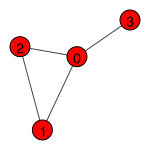

In [12]:
import igraph

g = igraph.Graph() # Create an empty graph
g.add_vertices(4) # Add 4 vertices
g.add_edges(edge_list) # Add edges to the graph

# Plot the graph
igraph.plot(g, bbox=(150, 150), vertex_label=list(range(4)))

### Shortest Paths

Let's compute the paths between nodes 2 and 3.

In [13]:
g.get_all_simple_paths(2, to=3)

[[2, 0, 3], [2, 1, 0, 3]]

This method enumerates all possible simple paths between two nodes. This is OK for small networks but quickly becomes impractical for larger networks, as the number of paths increases exponentially with the size of the network.

Often, we are interested in the shortest path, which is the path with the smallest number of edges. The shortest path can be computed by using the `get_shortest_paths` method.

In [14]:
g.get_shortest_paths(2, to=3)

[[2, 0, 3]]

Note that there can be multiple shortest paths between two nodes. If we are interested in the "length" instead of the path itself, there is a more efficient function `distances`.

In [15]:
g.distances(2, 3)

[[2]]

### Connected Components

In the simple network above, we can see that for every pair of nodes, we can find a path connecting them. This is the definition of a connected graph. We can check this property for a given graph:

In [16]:
components = g.connected_components()

The `components` is a special object called [VertexClustering](https://python.igraph.org/en/0.11.6/api/igraph.VertexClustering.html) in `igraph`.
It has the following useful functions and attributes:

In [17]:
print("membership: ", components.membership)  # the IDs of the component each node belongs to.
print("sizes: ", list(components.sizes()))  # the number of nodes in each component.
print("giant: ", components.giant())  # a subgraph of the largest connected component.

membership:  [0, 0, 0, 0]
sizes:  [4]
giant:  IGRAPH U--- 4 4 --
+ edges:
0--1 1--2 0--2 0--3


#### Exercise 01 🏋️‍♀️💪🧠

1. Now, let us add two nodes that are not connected to the existing graph, and call `connected_components` again. 🔗➕

2. Call `get_shortest_paths` between the two new nodes in different connected components. 🛣️🔍

3. Get the largest connected component. 🌐🏆

### Directed networks
Let's extend these ideas about paths and connected components to directed graphs.

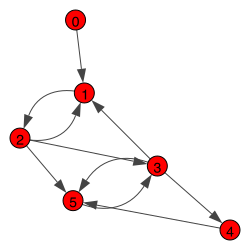

In [18]:
edge_list =[(0, 1), (1, 2), (2, 1), (2, 3), (2, 5), (3, 1), (3, 4), (3, 5), (4, 5), (5, 3)]
g = igraph.Graph(directed=True)
g.add_vertices(6)
g.add_edges(edge_list)
igraph.plot(g, bbox=(250, 250), vertex_label=list(range(6)))

In directed graphs, edges and paths can be one-way. For instance, in our graph, you can go from node 0 to node 3, but not from 3 to 0.

In [19]:
print("From 0 to 3", g.get_all_simple_paths(0, to=3))
print("From 3 to 0", g.get_all_simple_paths(3, to=0))

From 0 to 3 [[0, 1, 2, 3], [0, 1, 2, 5, 3]]
From 3 to 0 []


The shortest path from 4 to 1 must take a longer route due to edge directions.

In [20]:
g.get_shortest_paths(4, 1)

[[4, 5, 3, 1]]

Directed networks have two kinds of connected components.

- **Strongly connected components:** Strongly connected means that there exists a direct path between every pair of nodes, i.e., that from any node to any other nodes while respecting the edge directionality.
- **Weakly connected components:** Weakly connected means that there exists a path between every pair of nodes when ignoring the edge directionality.

In [21]:
print(list(g.connected_components(mode="strong")))
print(list(g.connected_components(mode="weak")))

[[0], [1, 2, 3, 4, 5]]
[[0, 1, 2, 3, 4, 5]]


## Scipy

We can create a graph, compute the shortest paths, and connected components using `scipy`.

### Create a graph


With scipy, we represent a network by an adjacency matrix using something called a *Compressed Sparse Row (CSR) matrix*. CSR matrices are efficient format for storing and manipulating *sparse* matrices. Why *sparse* is highlighed here? Because in many networks, the adjacency matrix is sparse, i.e., most of the entries are zero. For example, here is the adjacency matrix of a real-world network:

![](https://www.researchgate.net/publication/263506932/figure/fig1/AS:392539896074252@1470600212952/Scale-free-Network-left-its-adjacency-matrix-upper-right-and-degree-distribution.png)

Most of the entries in this adjacency matrix are white, and white means that the value of the entry is zero. And the adjacency matrix looks very white! This is pretty common in real-world networks. We call these matrices "sparse" because they are mostly empty. And CSR matrices are a way to store these sparse matrices efficiently. Don't worry too much about the technical details for now. If you're curious to learn more, you can check out the [Appendix](appendix.md).

The great thing is, `scipy` (especially the `scipy.sparse` module) provides efficient tools for working with these sparse matrices. This comes in really handy when we're working with large networks.

Let create a graph using scipy.

In [22]:
from scipy import sparse # We will use sparse module in scipy

edge_list = [(0, 1), (1, 2), (0, 2), (0, 3)]

src = [src for src, dst in edge_list]
trg = [dst for src, dst in edge_list]
weight = [1 for src, dst in edge_list]

A = sparse.csr_matrix((weight, (src, trg)), shape=(4, 4))
A = A + A.T # Make the adjacency matrix symmetric
A

<4x4 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

Let's break down the code.
- `src` and `trg` are the source and target nodes of the edges.
- `weight` is the weight of the edges.
- `sparse.csr_matrix((weight, (src, trg)))` creates a sparse matrix, filling `weight` into the positions specified by `(src, trg)`.
- `A.T` is the transpose of `A` and `A + A.T` makes the adjacency matrix symmetric.

The CSR matrix does not print nicely. But you can see it by converting to a numpy array and printing it.

In [23]:
A.toarray()

array([[0, 1, 1, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [1, 0, 0, 0]])

## Shortest Paths

The `sparse` module has a submodule `csgraph` that provides APIs for network analysis.

For example, `csgraph.shortest_path` computes the shortest path length from a specific node to all other nodes.

In [24]:
from scipy.sparse import csgraph

# `indices` is the node to compute the shortest path from.
D = csgraph.shortest_path(A, indices=2, directed=False)
D

array([1., 1., 0., 2.])

**Advanced:** If you want to get the actual paths (i.e., list of nodes in the path), you can pass `return_predecessors=True` to `csgraph.shortest_path`.

In [25]:
D, predecessors = csgraph.shortest_path(A, indices=2, directed=False, return_predecessors=True)

## Connected Components

Connected components can be computed by `csgraph.connected_components`.

In [26]:
n_components, labels = csgraph.connected_components(A, directed=False, return_labels=True)

print("Number of connected components:", n_components)
print("Labels:", labels)

Number of connected components: 1
Labels: [0 0 0 0]


- `n_components` is the number of connected components.
- `labels` is an array of length `n_nodes` where each element is the ID of the connected component the node belongs to.


## Exercise 02 🏋️‍♀️💪🧠

Let's compute the average path length of a network from pre-existing data and check if how long on average it takes to go from any node to any other node.

1. Select a network of your choice from [Netzschleuder](https://networks.skewed.de/). For convenience, choose a network of nodes less than 5000.
2. Download the csv version of the data by clicking something like "3KiB" under `csv` column.
3. Unzip the file and find "edges.csv", open it with a text editor to familiarize yourself with the format.
4. Load the data using `pandas`.
5. Get the source and target nodes from the data to create an edge list.
6. Construct a graph from the edge list, either using `igraph` or `scipy`.
7. Compute the average path length

**Hint:** Finding all shortest paths is a qubic time operation with respect to the number of nodes, or simply put, it takes a long time to compute. So compute the "estimate" by sampling many pairs of nodes uniformly at random and computing the average path length.---
jupytext:
  cell_metadata_filter: -all
  formats: md:myst
  text_representation:
    extension: .Rmd
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.16.3
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
---

# Walks, Trails, Paths, and Connectedness

## Walks, Trails, Paths

While we have already used the term **path**, let us make clear its definition, together with other related terms.

- A **walk** is a sequence of nodes that are connected to form a continous route in a network. For instance, walk (0, 1, 2, 3) is a walk in the graph of the bridges of Konigsberg. But the sequence (0,2,3,1) is not a walk, because the node 0 is not directly connected to node 2.

- A **trail** is a walk with no repeated edge. For instance, walk (0, 1, 2, 3) is also a trail as it does not cross the same edge twice. But walk (0,2,3,1,3) is not a trail due to the repeated edge (1,3).

- A **path** is a walk without repeated node. For instance, walk (0,1,2,3) is a path. But walk (0, 1, 2, 1, 2, 3) is not a path due to the repeated node 1 and 2.

- When a walk starts and ends at the same node, it is called a **loop*. If the loop is a trail, it is called a **circuit**. If the loop is a path, it is called a **cycle**.

***Question***: Is a path always a trail, and is a trail always a path?

:::{figure-md} numbered-koningsberg-graph2

<img src= "../figs/labeled-koningsberg.jpg" width="30%">

Labeled Knigsberg graph

:::

- **Shortest Path** is the path with the smallest number of edges (or nodes) between two nodes.
A shortest path from node 0 to 2 is (0, 1, 2). Two nodes can have multiple shortest paths e.g., (0, 3, 2).
- **The shortest path length** is the number of edges in the shortest path, *not the number of nodes!* 👈👈

:::{note} Are there **shortest trails** and **shortest walks**?
Shortest trails and shortest walks are fundamentally equivalent to shortest paths. A shortest trail must visit each node only once (otherwise it would not be the shortest), and similarly, a shortest walk does not repeat nodes (otherwise it would not be the shortest), both forming a shortest path.
:::


## Connectedness

- A network is **connected** if there is a path between every pair of nodes.
- A network is **disconnected** if there is no path between some pairs of nodes.
- **A connected component** of a network is a set of nodes that are connected to each other.
- **The giant component** of a network is the largest connected component that contains a significant fraction of nodes in the network (in order of the number of nodes).

:::{figure-md} connected-components

<img src= "../figs/connected-component.jpg" width="50%">

connected components of a network. the nodes with the same color form a connected component.

:::

## Connectedness in directed networks

We call a network is *directed* if the edges have a direction. Example directed networks include the network of Web pages, the network of friendships on X, the network of citations on academic papers.

In a directed network, a walk must follow the edge directions. Paths, trails, and loops extend similarly to directed networks. But one thing to keep in mind: a walk may not be reversible, meaning there can be a walk from one node to another but not vice versa.

This leads to two different types of `connectedness` as follows:

- **Strong connectedness**: A directed network is said to be strongly connected if there is a path from every node to every other node.
- **Weak connectedness**: A directed network is said to be weakly connected if there is a path from every node to every other node on its *undirected* counterpart.


:::{figure-md} connected-components-directed

<img src= "../figs/connected-component-directed.jpg" width="50%">

connected components of a network. the nodes with the same color form a connected component.

:::

**Question**: Is a strongly-connected component always a weakly-connected component?

In the next section, we will learn how to compute the shortest paths and connected components of a network using a library [igraph](https://python.igraph.org/en/stable/).

# Why is our social network small world?


- ✍️ [It’s a small world!! 6 degrees of separation](http://estebanmoro.org/pdf/netsci_for_kids/6_degrees_of_separation.pdf) {footcite}`esteban-moro-worksheet`


```{footbibliography}
```
---
jupytext:
  cell_metadata_filter: -all
  formats: md:myst
  text_representation:
    extension: .Rmd
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.16.3
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
---


# Small-world experiment

How far are two people in a social network? Milgram and his colleagues conducted a series of expriment to find out in the 1960s.

:::{figure-md} milgram-small-world-experiment

<img src="../figs/milgram-small-world-experiment.png" width="70%">

Milgram's small world experiment.

:::


The experiment went as follows:
1. Milgram first sent out packets to randomly selected people in Omaha, Nebraska, and Wichita, Kansas.
2. The recipient was asked to send the packet to the target person in Boston if they knew them. If not, they were to forward it to someone they knew on a first-name basis who might know the target.
3. The recipient continued to forward the packet to their acquaintances until it reached the target.

The results were surprising: out of the 160 letters sent, 64 successfully reached the target person by the chain of nearly six people, which was later called **six degrees of separation**.
The results imply that, despite the fact that there were hundreds of millions of people in the United States, their social network was significantly compact, with two random people being connected to each other in only a few steps.

:::{tip}
The term "Six degrees of separation" is commonly associated with Milgram's experiment, but Milgram never used it. John Guare coined the term for his 1991 play and movie ["Six Degrees of Separation."](https://en.wikipedia.org/wiki/Six_Degrees_of_Separation_(film))
:::

The results were later confirmed independently.

-  Yahoo research replicate the Milgram's experiment by using emails. Started from more than 24,000 people, only 384 people reached the one of the 18 target person in 13 countries. Among the successful ones, the average length of the chain was about 4. When taken into account the broken chain, the average length was estimated between 5 and 7.{footcite}`goel2009social`

- Researchers in Facebook and University of Milan analyzed the social network n Facebook, which consisted of 721 million active users and 69 billion friendships. The average length of the shortest chain was found to be 4.74. {footcite}`backstrom2012four`

```{footbibliography}
```# Module 2: Small-world

## What to learn in this module

In this module, we will learn small-world experiments and conduct a small small-world experiment . We will learn:
- Small-world experiment by Milgram
- Different concepts of *distance*: path, walks, circuits, cycles, connectedness
- How to load a large sparse network efficiently into memory
- How to measure a *distance* between two nodes using `igraph`
- **Keywords**: small-world experiment, six degrees of separation, path, walks, circuits, cycles, connectedness, connected component, weakly connected component, strongly connected component, compressed sparse row format.
---
jupytext:
  cell_metadata_filter: -all
  formats: md:myst
  text_representation:
    extension: .Rmd
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.16.3
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
---



# Toolbox for network analysis

Here are some useful tools for network analysis in Python:

- [Python built-in data structures](https://docs.python.org/3/tutorial/datastructures.html) (list, tuple, dict)
- [networkx](https://networkx.org/) - a beginner-friendly library for network analysis
- [igraph](https://igraph.org/python/) - a mature library with a wide range of algorithms
- [graph-tool](https://graph-tool.skewed.de/) - for stochastic block models
- [scipy](https://scipy.org/) - for analyzing large networks
- [pytorch-geometric](https://pytorch-geometric.readthedocs.io/en/latest/) - for graph neural networks

While `networkx` is a popular and beginner-friendly library for network analysis in Python, we'll be using `igraph` in this course. `igraph` is a mature library with a wide range of algorithms, originally developed for R.
Why `igraph` instead of `networkx`?
Because networkx has some persistent bugs in the implementations of some algorithms (e.g., LFR benchmark and weighted degree assortativity), which can skew the analysis.
`igraph` offers more reliable implementations.

We'll also use `scipy` for scientific computing. `scipy` is one of the most popular Python libraries and also a powerful network analysis tool, especially for large networks. While it requires a bit more effort to learn, once you get the hang of it, you'll find it's a powerful tool for your network analysis projects.

![](../figs/scipy.jpg)


---
jupytext:
  cell_metadata_filter: -all
  formats: md:myst
  text_representation:
    extension: .Rmd
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.16.3
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
---

# Wikirace

Let us feel how small a large network can be by playing the [Wikirace](https://wiki-race.com) game.

<div align="center">
  <img src="https://cdn.sparkfun.com/assets/home_page_posts/3/8/8/0/Wikirace.jpeg" alt="Wikirace" width="70%">
</div>



### What's next

At the end of the module, we will measure the average path length in a social network.
Before jumping on, let us arm with some coding techniques to handle the network in the next two sections.

```{bibliography}
:style: unsrt
:filter: docname in docnames
```